In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense



In [2]:

# Load the data
df = pd.read_csv('Commodity Prices Monthly.csv')

In [3]:
df.head()

,Year,Variables,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2023,International Brent Crude Oil Price (US$/Barre...,83.94,83.92,79.65,82.74,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2022,International Brent Crude Oil Price (US$/Barre...,85.48,94.28,112.51,105.81,111.55,117.22,105.14,97.74,90.57,93.60,90.38,81.34
2,2021,International Brent Crude Oil Price (US$/Barre...,55.33,62.27,65.84,65.33,68.34,73.35,74.29,70.51,74.88,83.75,80.75,74.80
3,2020,International Brent Crude Oil Price (US$/Barre...,63.67,55.53,33.73,26.63,32.11,40.77,43.24,45.04,41.87,41.36,43.98,50.23
4,2019,International Brent Crude Oil Price (US$/Barre...,60.23,64.50,67.05,71.66,70.30,63.05,64.19,59.47,62.29,59.63,62.71,65.17


In [4]:
df.shape

(23, 14)

In [5]:
df.dtypes

Year           int64
Variables     object
Jan          float64
Feb          float64
Mar          float64
Apr          float64
May          float64
Jun          float64
Jul          float64
Aug          float64
Sep          float64
Oct          float64
Nov          float64
Dec          float64
dtype: object

In [6]:
# Melt the dataframe to have years and months in the same column
df = df.melt(id_vars=['Year', 'Variables'], var_name='Month', value_name='Price')

# Combine year and month into a single column
df['Date'] = pd.to_datetime(df['Year'].astype(str) + df['Month'], format='%Y%b')


In [7]:
df.shape

(276, 5)

In [8]:
# Set 'Date' as index
df.set_index('Date', inplace=True)

# Sort the index
df.sort_index(inplace=True)

In [9]:
df.head()

,Year,Variables,Month,Price
Date,,,,
2000-01-01,2000,International Brent Crude Oil Price (US$/Barre...,Jan,25.19
2000-02-01,2000,International Brent Crude Oil Price (US$/Barre...,Feb,24.57
2000-03-01,2000,International Brent Crude Oil Price (US$/Barre...,Mar,27.25
2000-04-01,2000,International Brent Crude Oil Price (US$/Barre...,Apr,23.28
2000-05-01,2000,International Brent Crude Oil Price (US$/Barre...,May,27.39


In [10]:
df.shape

(276, 4)

In [11]:
# Plot the data
fig = px.line(df, x=df.index, y='Price', title='Brent Crude Oil Price Over Time')
fig.show()

In [12]:
# DECOMPOSE THE TIME SERIES
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Price'], model='multiplicative', period=12)

# Plot the decomposed time series with plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=result.trend, mode='lines', name='Trend'))
fig.add_trace(go.Scatter(x=df.index, y=result.seasonal, mode='lines', name='Seasonal'))
fig.add_trace(go.Scatter(x=df.index, y=result.resid, mode='lines', name='Residual'))
fig.update_layout(title='Decomposition of Brent Crude Oil Price', xaxis_title='Date', yaxis_title='Price')
fig.show()

ValueError: Multiplicative seasonality is not appropriate for zero and negative values

In [ ]:
# Perform Dickey-Fuller test
dftest = adfuller(df['Price'].dropna(), autolag='AIC')

# Create a Series with the Dickey-Fuller test results
# dftest[0:4] selects the first four elements of the tuple returned by adfuller:
# the test statistic, the p-value, the number of lags used, and the number of observations used
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

# dftest[4].items() is a dictionary of the critical values for the test statistic at the 1 %, 5 %, and 10 % levels
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Test Statistic                  -2.312073
p-value                          0.168104
#Lags Used                       1.000000
Number of Observations Used    274.000000
Critical Value (1%)             -3.454444
Critical Value (5%)             -2.872147
Critical Value (10%)            -2.572422
dtype: float64


In [ ]:
# The p-value(=0.168104) is greater than 0.05, so we fail to reject the null hypothesis that the time series is non-stationary.


In [ ]:
# Differencing the series
df['Price_diff'] = df['Price'] - df['Price'].shift(1)

# Dropping missing values
df.dropna(inplace=True)

# Perform Dickey-Fuller on differenced series
print('Results of Dickey Fuller Test on Differenced Series:')
dftest = adfuller(df['Price_diff'].dropna(), autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dickey Fuller Test on Differenced Series:
Test Statistic                -1.352690e+01
p-value                        2.667700e-25
#Lags Used                     0.000000e+00
Number of Observations Used    2.740000e+02
Critical Value (1%)           -3.454444e+00
Critical Value (5%)           -2.872147e+00
Critical Value (10%)          -2.572422e+00
dtype: float64


The p-value in your output is 2.667700e-25 (a very small number close to 0), which is less than the common significance level 0.05. This means we reject the null hypothesis of the Augmented Dickey-Fuller test, which states that the time series has a unit root and is non-stationary.

In simpler terms, your differenced time series is likely stationary. This means you've successfully transformed your time series and can proceed with the next steps of your analysis.

In [ ]:
# plot the differenced series
fig = px.line(df, x=df.index, y='Price Diff', title='Differenced Brent Crude Oil Price Over Time')
fig.show()


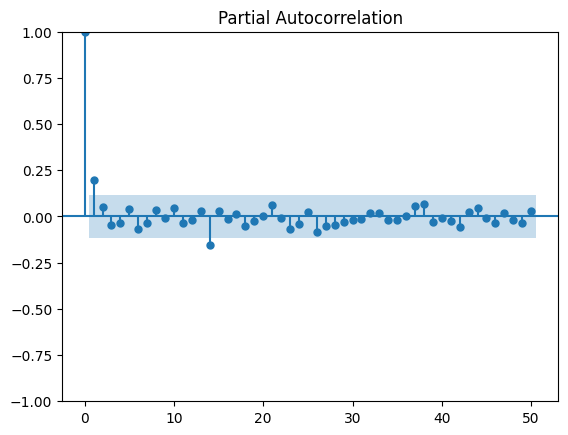

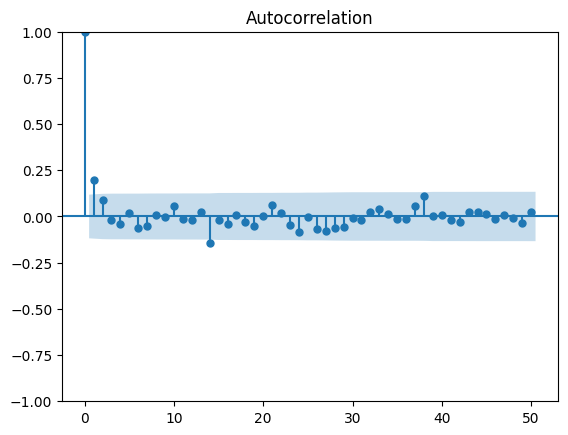

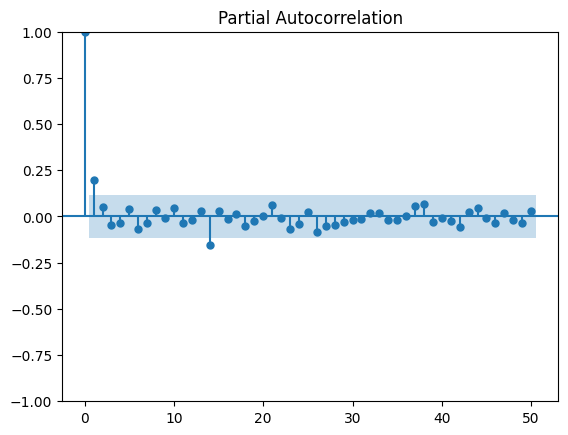

In [ ]:

# Plot the ACF
plot_acf(df['Price_diff'], lags=50)

# Plot the PACF
plot_pacf(df['Price_diff'], lags=50)

In [ ]:
# Fit an ARIMA model
model = ARIMA(df['Price'], order=(2,1,3))
model_fit = model.fit()


d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  275
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -937.796
Date:                Wed, 06 Mar 2024   AIC                           1887.593
Time:                        23:19:25   BIC                           1909.272
Sample:                             0   HQIC                          1896.294
                                - 275                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0806      0.040      1.991      0.047       0.001       0.160
ar.L2         -0.9790      0.049    -20.170      0.000      -1.074      -0.884
ma.L1          0.0967      0.051      1.888      0.0

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit a SARIMAX(1, 1, 1)x(1, 1, 1, 12) model
model = SARIMAX(df['Price'], order=(2,1,3), seasonal_order=(2,1,3,12))
model_fit = model.fit()

# Print out the statistics
print(model_fit.summary())

d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                     SARIMAX Results                                      
Dep. Variable:                              Price   No. Observations:                  275
Model:             SARIMAX(2, 1, 3)x(2, 1, 3, 12)   Log Likelihood                -915.814
Date:                            Wed, 06 Mar 2024   AIC                           1853.629
Time:                                    23:28:15   BIC                           1892.881
Sample:                                         0   HQIC                          1869.405
                                            - 275                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2276      0.460     -0.494      0.621      -1.130       0.675
ar.L2         -0.7304      0.327   

In [ ]:
# Define the preprocess_for_lstm function
def preprocess_for_lstm(data):
    # Implement your data preprocessing logic here
    pass

# Assuming df is your DataFrame and 'price' is the column of interest
# Preprocess your data to fit into LSTM model
X_train, y_train, X_test, y_test = preprocess_for_lstm(df['Price'])

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit the model
model.fit(X_train, y_train, epochs=200, verbose=0)

NameError: name 'preprocess_for_lstm' is not defined

In [ ]:
%pip install %pip install fbprophet
fbprophet
from fbprophet import Prophet

# Prophet requires the variable names in the time series to be
# y for the response, and ds for the date
df.columns = ['ds', 'y']

model = Prophet()
model.fit(df)

# Make future predictions
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '%pip'


NameError: name 'fbprophet' is not defined